In [163]:
import json
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, LSTM

In [164]:
sb.set_palette('Set1')

In [165]:
histogram = pd.read_csv('case_time_series.csv')
histogram = histogram.set_index('Date')

In [166]:
target_col = 'cases'

In [167]:
def train_test_split(df, test_size = 0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    
    return train_data, test_data

In [168]:
train, test = train_test_split(histogram, test_size = 0.1)

In [169]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, graph = plt.subplots(1, figsize=(16, 9))
    graph.set_facecolor('#00000000')
    graph.plot(line1, label=label1, linewidth=lw)
    graph.plot(line2, label=label2, linewidth=lw)
    graph.set_ylabel('SARS-CoV-2 Cases (Millions)', fontsize=16)
    graph.set_xlabel('Dates', fontsize=16)
    graph.set_title(title, fontsize=20)
    graph.legend(loc='best', fontsize=12);
    graph.xaxis.set_major_locator(plt.MaxNLocator(15))
    graph.xaxis.grid()
    graph.yaxis.grid()

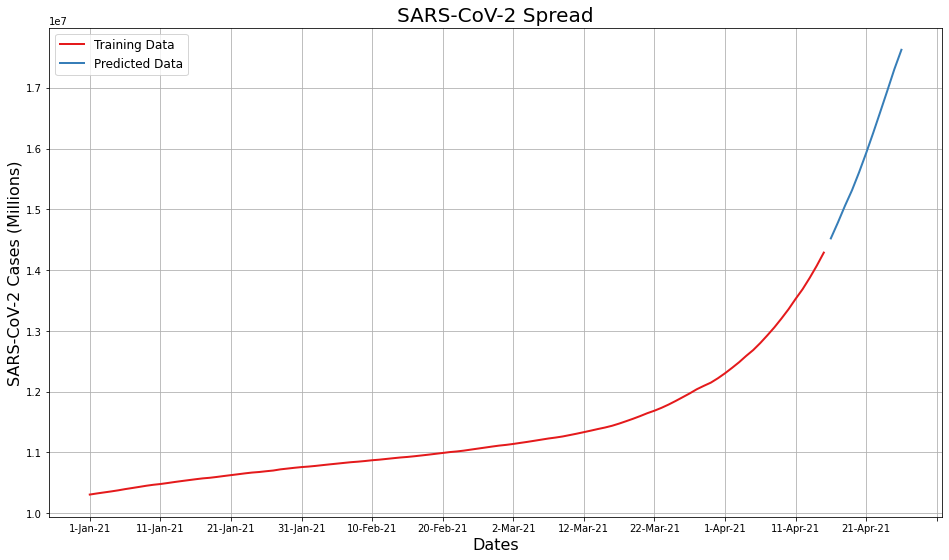

In [170]:
line_plot(train[target_col], test[target_col], 'Training Data', 'Predicted Data', title='SARS-CoV-2 Spread')

In [171]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

In [172]:
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [173]:
def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        
        if zero_base:
            tmp = normalise_zero_base(tmp)
            
        window_data.append(tmp.values)
        
    return np.array(window_data)

In [174]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [175]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear', dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [176]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 2
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [177]:
train, test, X_train, X_test, y_train, y_test = prepare_data(histogram, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [178]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
49/49 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 11/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 12/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 13/50
49/49 [==============================

In [179]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

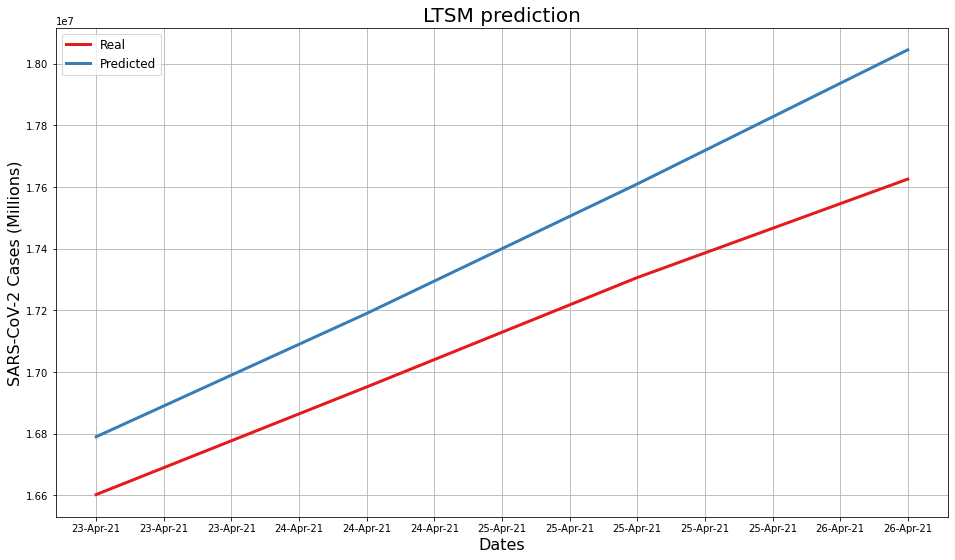

In [180]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'Real', 'Predicted', lw=3, title='LTSM prediction')